In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import pylab
import gwpy
import gwosc
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import  FrequencySeries
import matplotlib.colors as mplc
from pycbc.waveform import get_td_waveform, get_fd_waveform
from numpy import float64 as fl
from pycbc.filter import matched_filter
from pycbc.events.ranking import newsnr
from pycbc.vetoes import power_chisq


In [3]:
src_dir=os.getcwd()
main_dir=os.path.dirname(src_dir)
data_dir=os.path.join(main_dir,"data")


# CHALLENGE 1
## 1. Load the data into memory.  What are the sampling rate and duration of the data?

In [14]:
gwpy_1=TimeSeries.read(os.path.join(data_dir,"challenge1.gwf"), "H1:CHALLENGE1")

In [15]:
print(f"The duration is {gwpy_1.duration}s and the sample rate is {gwpy_1.sample_rate}Hz")

The duration is 128.0 ss and the sample rate is 4096.0 HzHz


## 2. Plot the data in the time-domain.

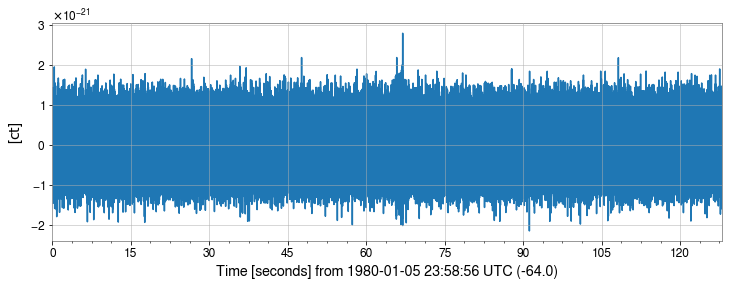

In [16]:
#plot of the signal
#plt.plot(gwf_1.sample_times,gwf_1)
gwpy_1.plot()
print("")

## 3. Plot a spectrogram (or q-transform) of the data, and try to identify the signal.


In [17]:

qt_1=gwpy_1.q_transform(frange=(20,500), qrange=(20, 40))

(-15.0, 15.0)

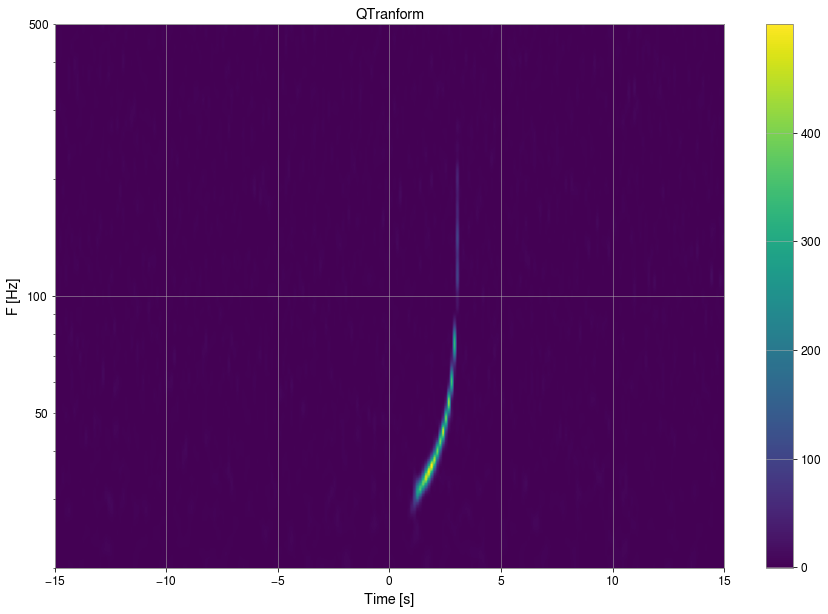

In [18]:
plt.figure(figsize=(15,10))

plt.imshow(qt_1,origin="lower",aspect="auto",extent=(np.float64(gwpy_1.times[0]),np.float64(gwpy_1.times[-1]),20,500))
plt.colorbar()

plt.title("QTranform")
plt.xlabel("Time [s]")
plt.ylabel("F [Hz]")
plt.yscale("log")
plt.xlim(-15,15)

## 4. What is the time of the merger?

(2.0, 3.5)

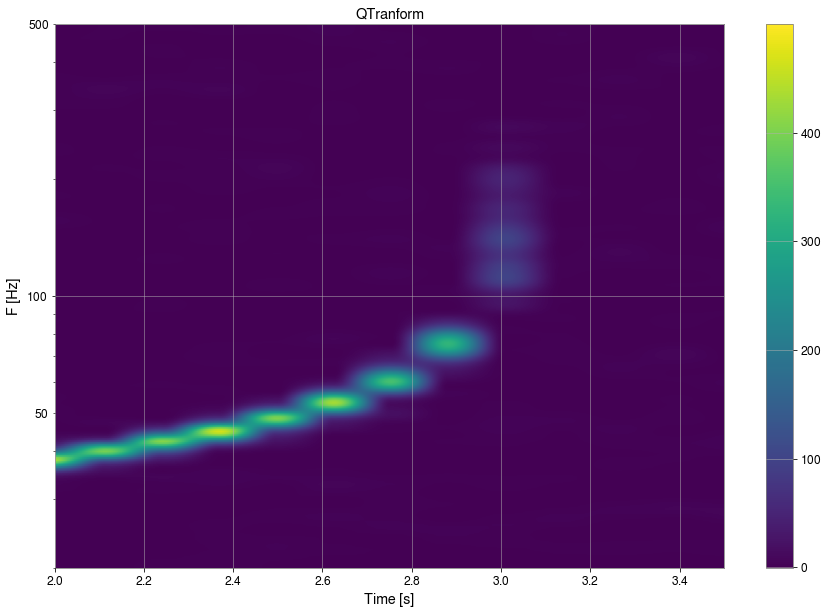

In [28]:
plt.figure(figsize=(15,10))

plt.imshow(qt_1,origin="lower",aspect="auto",extent=(gwpy_1.times[0].value,gwpy_1.times[-1].value,20,500))
plt.colorbar()

plt.title("QTranform")
plt.xlabel("Time [s]")
plt.ylabel("F [Hz]")
plt.yscale("log")
plt.xlim(2,3.5)

In [29]:
print("The time of the merger is approximately at 3s")

The time of the merger is approximately at 3s


In [30]:
gwpy_1.times[0].value

-64.0

# CHALLENGE 2

## 1. What is the approximative time of the merger? (Hint: a plot of the q-transform could help)

In [31]:
gwpy_2=TimeSeries.read(os.path.join(data_dir,"challenge2.gwf"), "H1:CHALLENGE2")

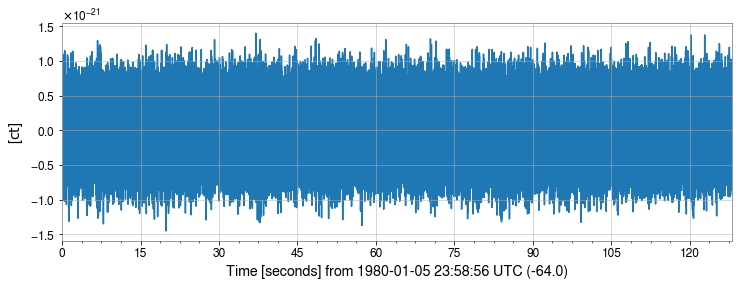

In [32]:
gwpy_2.plot()
print("")

In [33]:
qt_2=gwpy_2.q_transform(frange=(10,200), qrange=(5, 10))

(-18.0, -12.0)

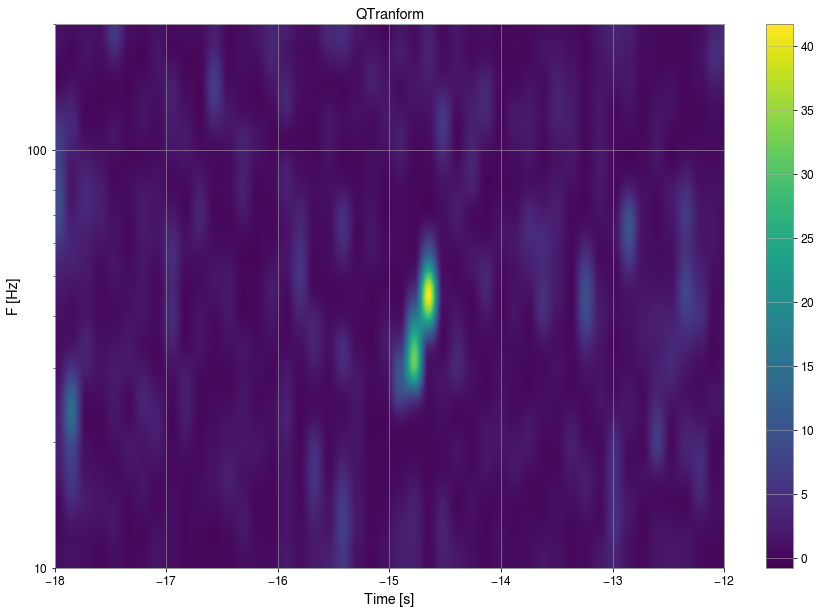

In [34]:
plt.figure(figsize=(15,10))

plt.imshow(qt_2,origin="lower",aspect="auto",extent=(np.float64(gwpy_2.times[0]),np.float64(gwpy_2.times[-1]),10,200))
plt.colorbar()

plt.title("QTranform")
plt.xlabel("Time [s]")
plt.ylabel("F [Hz]")
plt.yscale("log")
plt.xlim(-18,-12)

(-15.0, -14.5)

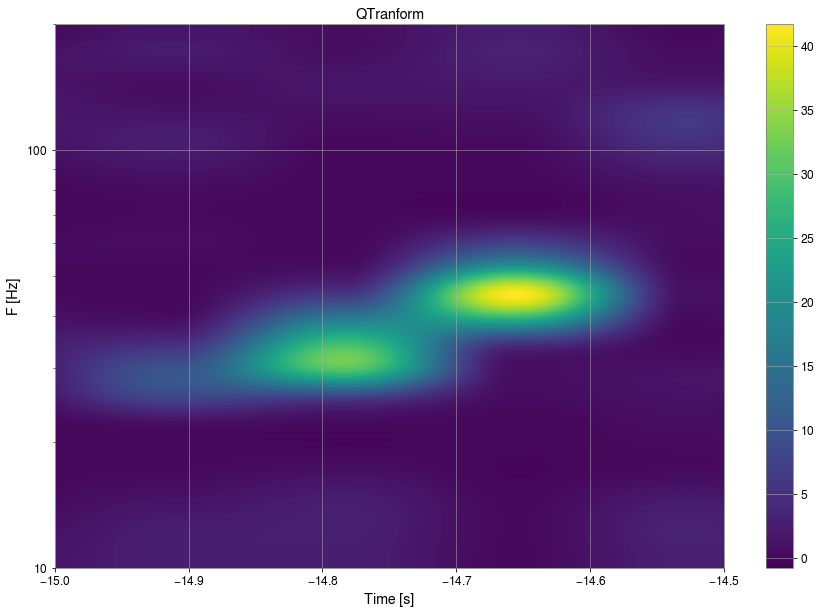

In [35]:
plt.figure(figsize=(15,10))

plt.imshow(qt_2,origin="lower",aspect="auto",extent=(np.float64(gwpy_2.times[0]),np.float64(gwpy_2.times[-1]),10,200))
plt.colorbar()

plt.title("QTranform")
plt.xlabel("Time [s]")
plt.ylabel("F [Hz]")
plt.yscale("log")
plt.xlim(-15,-14.5)

In [36]:
print("The time of the merger is approximatly -14.6s")

The time of the merger is approximatly -14.6s


## 3. Calculate a PSD of the data, and plot this on a log-log scale.  Use axes ranging from 20 Hz up to the Nyquist frequency.

Text(0.5, 1.0, 'PSD of raw signal')

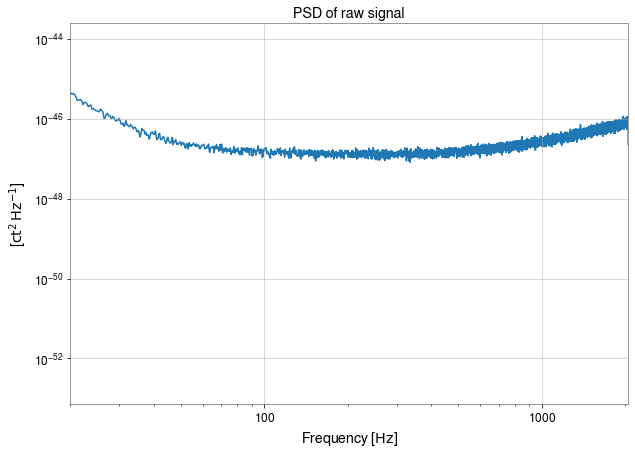

In [37]:
gwpy_2.psd(4).plot(figsize=(10,7))
plt.xlim(20,fl(gwpy_2.sample_rate)/2)
plt.title("PSD of raw signal")

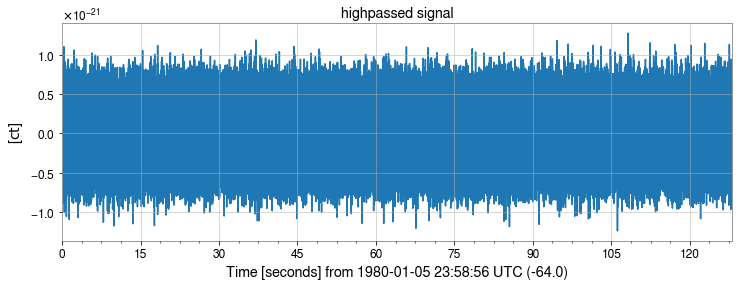

In [38]:
gw2_hp =gwpy_2.highpass(20)
gw2_hp.plot()
plt.title("highpassed signal")
print("")

Text(0.5, 1.0, 'PSD of highpassed signal')

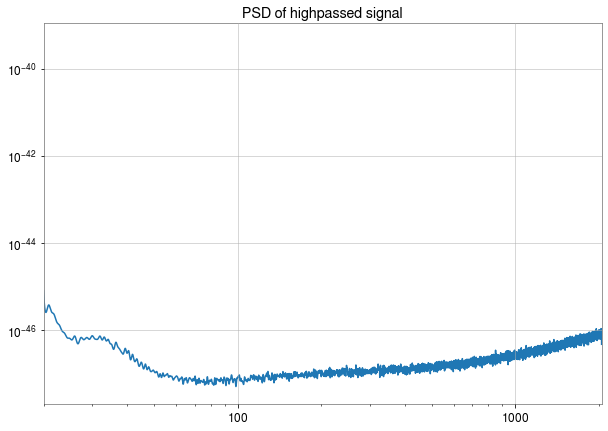

In [39]:
psd_hp=gw2_hp.psd(4)

psd_hp=psd_hp.to_pycbc()

gw2_cbc=gw2_hp.to_pycbc()
gw2_cbc=resample_to_delta_t(gw2_cbc, 1.0/2048)
gw2_cbc=gw2_cbc.crop(2, 2)

psd_hp = interpolate(psd_hp, gw2_cbc.delta_f)


psd_hp =inverse_spectrum_truncation(psd_hp, int(4 * gw2_cbc.sample_rate),low_frequency_cutoff=20)



plt.figure(figsize=(10,7))
plt.plot(psd_hp.sample_frequencies,psd_hp)
plt.xlim(20,fl(gwpy_2.sample_rate)/2)
plt.xscale("log")
plt.yscale("log")
plt.title("PSD of highpassed signal")

## 2. Generate a time-domain template waveform using approximate "SEOBNRv4_opt". With the same parameters as above.  Plot this waveform.

In [40]:
m=30
sim, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=gw2_cbc.delta_t,
                     f_lower=20)


Text(0.5, 1.0, 'Template wave')

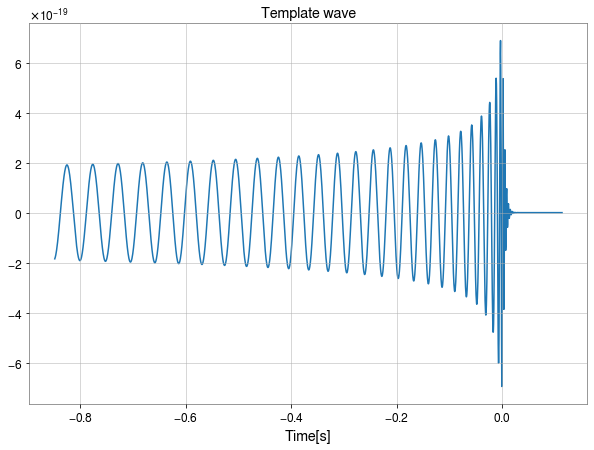

In [41]:
plt.figure(figsize=(10,7))
plt.plot(sim.sample_times,sim)
plt.xlabel("Time[s]")
plt.title("Template wave")

##  4. Use the template waveform and PSD to calculate the SNR time series.  Plot the SNR time-series.

In [42]:

sim.resize(len(gw2_cbc))
sim = sim.cyclic_time_shift(sim.start_time)


In [43]:
snr = matched_filter(sim, gw2_cbc,psd=psd_hp, low_frequency_cutoff=20)


Text(0.5, 1.0, 'SNR(t) of highpassed signal')

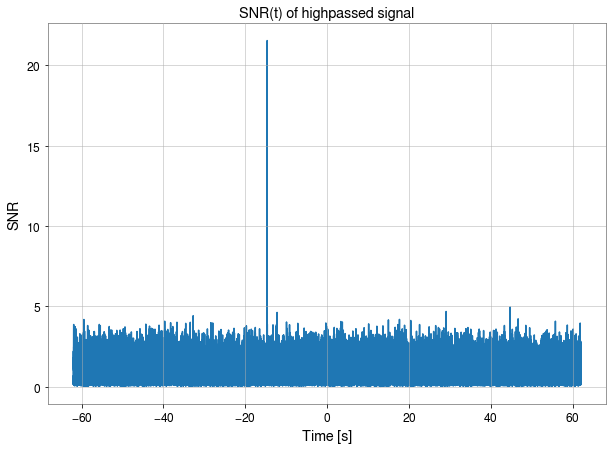

In [44]:
plt.figure(figsize=(10,7))
plt.plot(snr.sample_times,abs(snr))
plt.xlabel("Time [s]")
plt.ylabel("SNR")
plt.title("SNR(t) of highpassed signal")

In [45]:
print(f"The max value of the SNR is {max(abs(snr))}")

The max value of the SNR is 21.546056604798725


In [46]:
## 4. What is the time of the merger?

In [47]:
print(f"The time of merger is {snr.sample_times[np.argmax(abs(snr))]} s")

The time of merger is -14.6328125 s


(-13.8, -15.0)

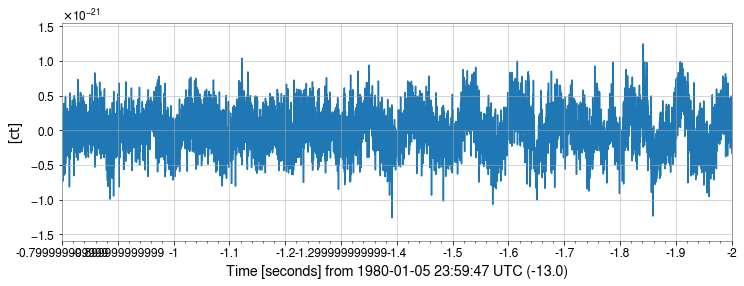

In [48]:
gwpy_2.plot()
plt.xlim(-13.8,-15)
#plt.plot(sim.sample_times,sim)

# Challenge 3 

## 1. What is the merger time of this signal?
## 2. What is the matched-filter SNR of this signal?

In [4]:
gwpy_3=TimeSeries.read(os.path.join(data_dir,"challenge3.gwf"), "H1:CHALLENGE3")

In [5]:
len(gwpy_3)

16777216

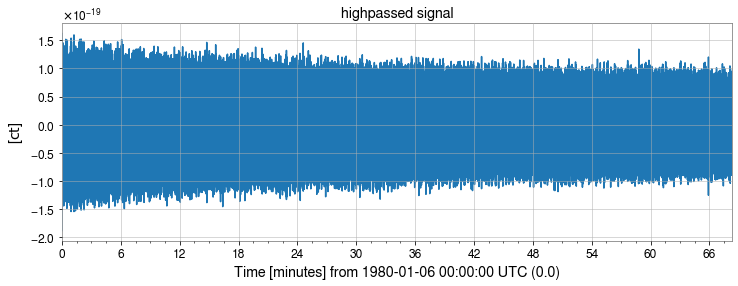

In [6]:
gw3_hp =gwpy_3.highpass(20)

gw3_hp.plot()
plt.title("highpassed signal")
print("")

In [7]:
len(gw3_hp)

16777216

Text(0.5, 1.0, 'PSD of highpassed signal')

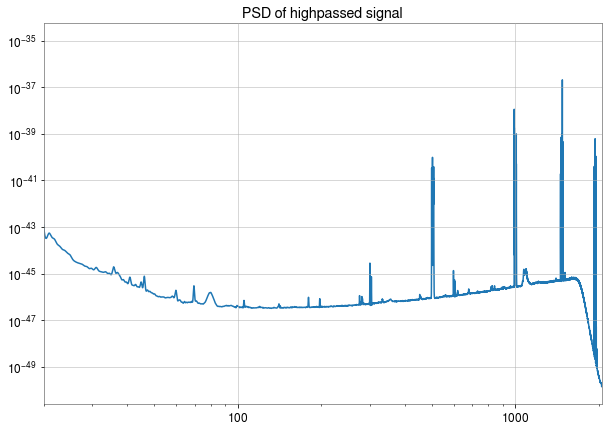

In [8]:
psd_hp=gw3_hp.psd(4)

psd_hp=psd_hp.to_pycbc()

gw3_cbc=gw3_hp.to_pycbc()
#gw3_cbc=resample_to_delta_t(gw3_cbc, 1.0/2048)
gw3_cbc=gw3_cbc.crop(2, 2)

psd_hp = interpolate(psd_hp, gw3_cbc.delta_f)


psd_hp =inverse_spectrum_truncation(psd_hp, int(2 * gw3_cbc.sample_rate),low_frequency_cutoff=20)



plt.figure(figsize=(10,7))
plt.plot(psd_hp.sample_frequencies,psd_hp)
plt.xlim(20,fl(gwpy_3.sample_rate)/2)
plt.xscale("log")
plt.yscale("log")
plt.title("PSD of highpassed signal")

In [9]:
len(gw3_cbc)

16760832

In [10]:
m=10
sim, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=gw3_cbc.delta_t,
                     f_lower=20)

Text(0.5, 1.0, 'Template wave')

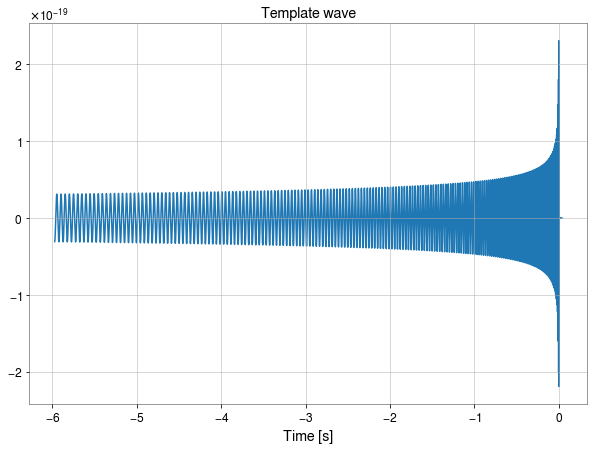

In [11]:
plt.figure(figsize=(10,7))
plt.plot(sim.sample_times,sim)
plt.xlabel("Time [s]")
plt.title("Template wave")

In [12]:

sim.resize(len(gw3_cbc))
sim = sim.cyclic_time_shift(sim.start_time)


In [13]:
snr = matched_filter(sim, gw3_cbc,psd=psd_hp, low_frequency_cutoff=20)

Text(0.5, 1.0, 'SNR(t) of highpassed signal')

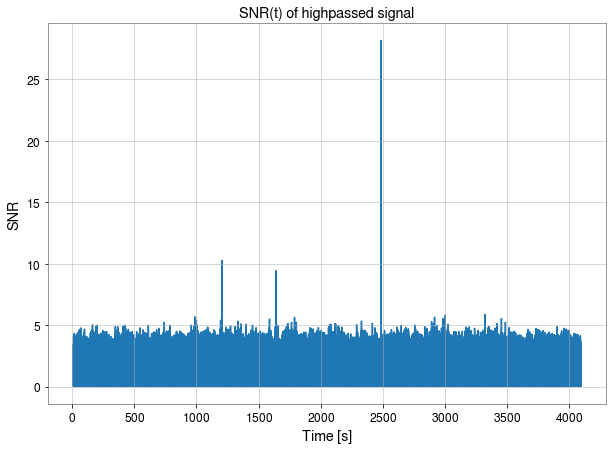

In [14]:
snr = snr.crop(8, 4)


plt.figure(figsize=(10,7))
plt.plot(snr.sample_times,abs(snr))
plt.xlabel("Time [s]")
plt.ylabel("SNR")
plt.title("SNR(t) of highpassed signal")

In [15]:
psd_hp_c=psd_hp[1::]

sim_freq, _ = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=m, mass2=m,
                         f_lower=20.0, delta_f=gw3_cbc.delta_f)



chisq = power_chisq(sim, gw3_cbc, 26, psd_hp, low_frequency_cutoff=20.0)

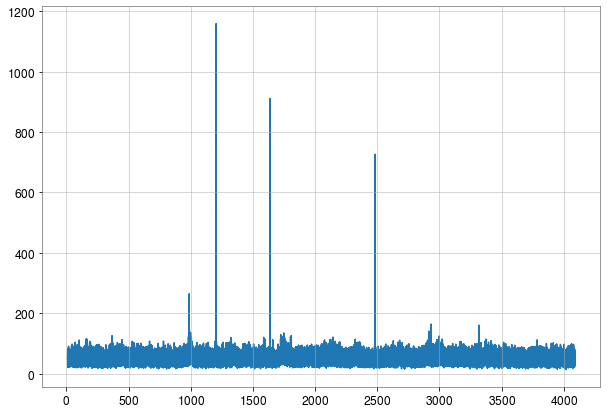

In [16]:
chisq=chisq.crop(8,4)
pylab.figure(figsize=(10,7))
pylab.plot(chisq.sample_times, chisq)


In [17]:
nsnr=newsnr(abs(snr), chisq)

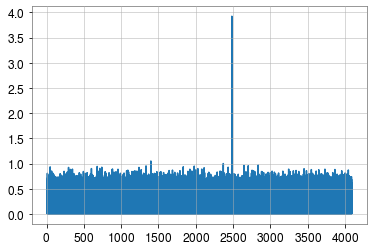

In [18]:
pylab.plot(snr.sample_times, nsnr)

In [21]:
print(f"SNR:{max(abs(snr))} t_peak:{snr.sample_times[np.argmax(abs(snr))]}")

SNR:28.15311935520547 t_peak:2483.967529296875
